In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [2]:
# !pip install --upgrade setuptools pip --user
# !pip install --ignore-installed PyYAML
# !pip install Pillow

# !pip install nvidia-pyindex
# !pip install --upgrade nvidia-tensorrt
# !pip install pycuda

# !pip install protobuf<4.21.3
# !pip install onnxruntime-gpu
# !pip install onnx>=1.9.0
# !pip install onnx-simplifier>=0.3.6 --user

In [3]:
import sys
import torch
print(f"Python version: {sys.version}, {sys.version_info} ")
print(f"Pytorch version: {torch.__version__} ")

Python version: 3.8.13 | packaged by conda-forge | (default, Mar 25 2022, 06:04:18) 
[GCC 10.3.0], sys.version_info(major=3, minor=8, micro=13, releaselevel='final', serial=0) 
Pytorch version: 1.12.1 


In [4]:
# !nvidia-smi

In [5]:
# !# Download YOLOv7 code
# !git clone https://github.com/WongKinYiu/yolov7
# %cd yolov7
%cd ..
!ls

/home/xin/OneDrive/xin/yolov7
best.pt        figure	    README.md	      train_aux.py
cfg	       hubconf.py   requirements.txt  train.py
customization  inference    runs	      utils
data	       LICENSE.md   scripts	      wandb
deploy	       models	    test.py	      yolov7-tiny.pt
detect.py      paper	    tools	      yolov7_training.pt
export.py      __pycache__  traced_model.pt


In [6]:
# !# Download trained weights
# !wget https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7-tiny.pt

In [6]:
# !python detect.py --weights runs/train/yolov7-tiny-custom/weights/best.pt --conf 0.5 --img-size 640 --source /home/xin/OneDrive/xin/cv/data/bones1.jpg

Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.5, device='', exist_ok=False, img_size=640, iou_thres=0.45, name='exp', no_trace=False, nosave=False, project='runs/detect', save_conf=False, save_txt=False, source='/home/xin/OneDrive/xin/cv/data/bones1.jpg', update=False, view_img=False, weights=['runs/train/yolov7-tiny-custom/weights/best.pt'])
YOLOR 🚀 55b90e1 torch 1.12.1 CUDA:0 (NVIDIA GeForce RTX 3090, 24268.3125MB)

Fusing layers... 
IDetect.fuse
/home/xin/anaconda3/envs/yolov7/lib/python3.8/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484683044/work/aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Model Summary: 208 layers, 6007596 parameters, 0 gradients, 13.0 GFLOPS
 Convert model to Traced-model... 
 traced_script_module saved! 
 model

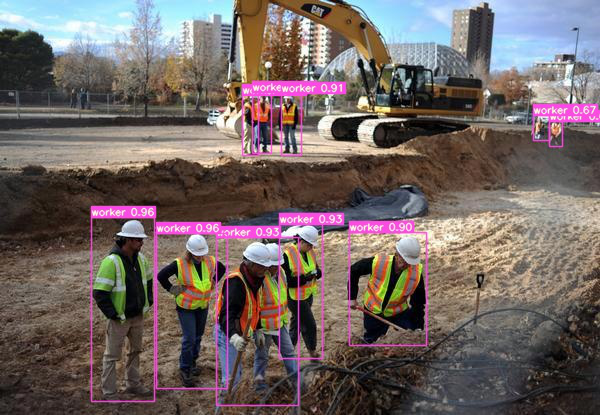

In [7]:
from PIL import Image
Image.open('runs/detect/exp4/bones1.jpg')

In [8]:
# export temporary ONNX model for TensorRT converter
!python export.py --weights cfg/deploy/yolov7-tiny-custom.pt --grid --end2end --simplify --topk-all 100 --iou-thres 0.65 --conf-thres 0.35 --img-size 640 640
!ls cfg/deploy

Namespace(batch_size=1, conf_thres=0.35, device='cpu', dynamic=False, dynamic_batch=False, end2end=True, fp16=False, grid=True, img_size=[640, 640], include_nms=False, int8=False, iou_thres=0.65, max_wh=None, simplify=True, topk_all=100, weights='cfg/deploy/yolov7-tiny-custom.pt')
YOLOR 🚀 55b90e1 torch 1.12.1 CPU

Fusing layers... 
/home/xin/anaconda3/envs/yolov7/lib/python3.8/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484683044/work/aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Model Summary: 200 layers, 6006646 parameters, 6006646 gradients, 13.0 GFLOPS

Starting TorchScript export with torch 1.12.1...
/home/xin/OneDrive/xin/yolov7/models/yolo.py:52: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record t

In [9]:
# Download ONNX to TensorRT converter
%cd ../
# !git clone https://github.com/Linaom1214/tensorrt-python.git

/home/xin/OneDrive/xin


In [10]:
%cd tensorrt-python
!ls

/home/xin/OneDrive/xin/tensorrt-python
cpp		image_batch.py	README.md  utils
Examples.ipynb	__pycache__	src	   yolov7-custom-nms.trt
export.py	README_CN.md	trt.py	   yolov7-tiny-nms.trt


In [11]:
# Export TensorRT-engine model 
!python export.py -o ../yolov7/cfg/deploy/yolov7-tiny-custom.onnx -e ./yolov7-tiny-custom-nms.trt -p fp16

Namespace(calib_batch_size=8, calib_cache='./calibration.cache', calib_input=None, calib_num_images=5000, conf_thres=0.4, end2end=False, engine='./yolov7-tiny-custom-nms.trt', iou_thres=0.5, max_det=100, onnx='../yolov7/cfg/deploy/yolov7-tiny-custom.onnx', precision='fp16', verbose=False, workspace=1)
[09/16/2022-23:57:40] [TRT] [I] [MemUsageChange] Init CUDA: CPU +320, GPU +0, now: CPU 343, GPU 2023 (MiB)
[09/16/2022-23:57:41] [TRT] [I] [MemUsageChange] Init builder kernel library: CPU +327, GPU +104, now: CPU 689, GPU 2127 (MiB)
export.py:109: DeprecationWarning: Use set_memory_pool_limit instead.
  self.config.max_workspace_size = workspace * (2 ** 30)
[09/16/2022-23:57:41] [TRT] [W] onnx2trt_utils.cpp:369: Your ONNX model has been generated with INT64 weights, while TensorRT does not natively support INT64. Attempting to cast down to INT32.
[09/16/2022-23:57:41] [TRT] [I] No importer registered for op: EfficientNMS_TRT. Attempting to import as plugin.
[09/16/2022-23:57:41] [TRT] [I

In [12]:
import cv2
import torch
import random
import time
import numpy as np
import tensorrt as trt
from PIL import Image
from pathlib import Path
from collections import OrderedDict,namedtuple

In [13]:
w = './yolov7-tiny-custom-nms.trt'
device = torch.device('cuda:0')
img = cv2.imread('/home/xin/OneDrive/xin/cv/data/bones1.jpg')

In [14]:
# Infer TensorRT Engine
Binding = namedtuple('Binding', ('name', 'dtype', 'shape', 'data', 'ptr'))
logger = trt.Logger(trt.Logger.INFO)
trt.init_libnvinfer_plugins(logger, namespace="")
with open(w, 'rb') as f, trt.Runtime(logger) as runtime:
    model = runtime.deserialize_cuda_engine(f.read())
bindings = OrderedDict()
for index in range(model.num_bindings):
    name = model.get_binding_name(index)
    dtype = trt.nptype(model.get_binding_dtype(index))
    shape = tuple(model.get_binding_shape(index))
    data = torch.from_numpy(np.empty(shape, dtype=np.dtype(dtype))).to(device)
    bindings[name] = Binding(name, dtype, shape, data, int(data.data_ptr()))
binding_addrs = OrderedDict((n, d.ptr) for n, d in bindings.items())
context = model.create_execution_context()


def letterbox(im, new_shape=(640, 640), color=(114, 114, 114), auto=True, scaleup=True, stride=32):
    # Resize and pad image while meeting stride-multiple constraints
    shape = im.shape[:2]  # current shape [height, width]
    if isinstance(new_shape, int):
        new_shape = (new_shape, new_shape)

    # Scale ratio (new / old)
    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    if not scaleup:  # only scale down, do not scale up (for better val mAP)
        r = min(r, 1.0)

    # Compute padding
    new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding

    if auto:  # minimum rectangle
        dw, dh = np.mod(dw, stride), np.mod(dh, stride)  # wh padding

    dw /= 2  # divide padding into 2 sides
    dh /= 2

    if shape[::-1] != new_unpad:  # resize
        im = cv2.resize(im, new_unpad, interpolation=cv2.INTER_LINEAR)
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)  # add border
    return im, r, (dw, dh)

def postprocess(boxes,r,dwdh):
    dwdh = torch.tensor(dwdh*2).to(boxes.device)
    boxes -= dwdh
    boxes /= r
    return boxes

names = ['person']
colors = {name:[random.randint(0, 255) for _ in range(3)] for i,name in enumerate(names)}

[09/17/2022-00:04:13] [TRT] [I] [MemUsageChange] Init CUDA: CPU +329, GPU +0, now: CPU 401, GPU 2023 (MiB)
[09/17/2022-00:04:14] [TRT] [I] Loaded engine size: 13 MiB
[09/17/2022-00:04:14] [TRT] [I] [MemUsageChange] Init cuBLAS/cuBLASLt: CPU +809, GPU +348, now: CPU 1252, GPU 2385 (MiB)
[09/17/2022-00:04:14] [TRT] [I] [MemUsageChange] Init cuDNN: CPU +126, GPU +58, now: CPU 1378, GPU 2443 (MiB)
[09/17/2022-00:04:14] [TRT] [W] TensorRT was linked against cuDNN 8.4.1 but loaded cuDNN 8.3.2
[09/17/2022-00:04:14] [TRT] [I] [MemUsageChange] TensorRT-managed allocation in engine deserialization: CPU +0, GPU +0, now: CPU 0, GPU 0 (MiB)
[09/17/2022-00:04:15] [TRT] [I] [MemUsageChange] Init cuBLAS/cuBLASLt: CPU +0, GPU +8, now: CPU 2190, GPU 2817 (MiB)
[09/17/2022-00:04:15] [TRT] [I] [MemUsageChange] Init cuDNN: CPU +0, GPU +8, now: CPU 2190, GPU 2825 (MiB)
[09/17/2022-00:04:15] [TRT] [W] TensorRT was linked against cuDNN 8.4.1 but loaded cuDNN 8.3.2
[09/17/2022-00:04:15] [TRT] [I] [MemUsageChan

In [15]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
image = img.copy()
image, ratio, dwdh = letterbox(image, auto=False)
image = image.transpose((2, 0, 1))
image = np.expand_dims(image, 0)
image = np.ascontiguousarray(image)

im = image.astype(np.float32)
im.shape

(1, 3, 640, 640)

Cost 0.0009727138094604015 s


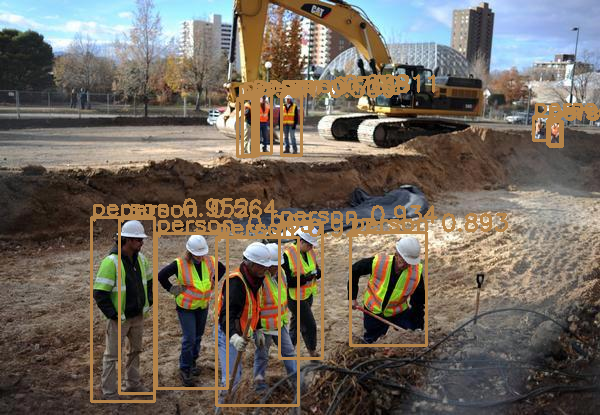

In [16]:
im = torch.from_numpy(im).to(device)
im/=255
im.shape

# warmup for 10 times
for _ in range(10):
    tmp = torch.randn(1,3,640,640).to(device)
    binding_addrs['images'] = int(tmp.data_ptr())
    context.execute_v2(list(binding_addrs.values()))

start = time.perf_counter()
binding_addrs['images'] = int(im.data_ptr())
context.execute_v2(list(binding_addrs.values()))
print(f'Cost {time.perf_counter()-start} s')

nums = bindings['num_dets'].data
boxes = bindings['det_boxes'].data
scores = bindings['det_scores'].data
classes = bindings['det_classes'].data
nums.shape,boxes.shape,scores.shape,classes.shape

boxes = boxes[0,:nums[0][0]]
scores = scores[0,:nums[0][0]]
classes = classes[0,:nums[0][0]]

for box,score,cl in zip(boxes,scores,classes):
    box = postprocess(box,ratio,dwdh).round().int()
    name = names[cl]
    color = colors[name]
    name += ' ' + str(round(float(score),3))
    cv2.rectangle(img,box[:2].tolist(),box[2:].tolist(),color,2)
    cv2.putText(img,name,(int(box[0]), int(box[1]) - 2),cv2.FONT_HERSHEY_SIMPLEX,0.75,color,thickness=2)

Image.fromarray(img)